## НАШ ПРОЕКТИК

# 1. Получение данных


In [1]:
import requests
import pandas as pd
from datetime import datetime

# Геокоординаты для нужных городов
city_coords = {
    'Moscow': (55.7558, 37.6176),
    'Saint_Petersburg': (59.9343, 30.3351),
    'Nizhny_Novgorod': (56.2965, 43.9361),
    'Kazan': (55.7963, 49.1088),
    'Ufa': (54.7388, 55.9721),
    'Novosibirsk': (55.0084, 82.9357),
    'Vladivostok': (43.1198, 131.8869)
}

# Функция получения данных из Open-Meteo
def get_weather_open_meteo(city: str, lat: float, lon: float,
                           start_date='2023-01-01', end_date='2023-12-31',
                           hourly=True) -> pd.DataFrame:
    base_url = 'https://archive-api.open-meteo.com/v1/archive'
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': start_date,
        'end_date': end_date,
        'timezone': 'auto'
    }

    if hourly:
        params['hourly'] = 'temperature_2m'
    else:
        params['daily'] = 'temperature_2m_mean'

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        raise Exception(f'Ошибка {response.status_code}: {response.text}')
    
    data = response.json()
    
    if hourly:
        time_list = data['hourly']['time']
        temp_list = data['hourly']['temperature_2m']
    else:
        time_list = data['daily']['time']
        temp_list = data['daily']['temperature_2m_mean']
    
    df = pd.DataFrame({
        'datetime': pd.to_datetime(time_list),
        'temperature': temp_list
    })
    df['city'] = city
    return df

# Сбор всех данных
hourly_data = []
daily_data = []

for city, (lat, lon) in city_coords.items():
    print(f"[⏱] Загружаем почасовые данные для: {city}")
    df_hourly = get_weather_open_meteo(city, lat, lon, hourly=True)
    hourly_data.append(df_hourly)
    
    print(f"[📆] Загружаем ежедневные данные для: {city}")
    df_daily = get_weather_open_meteo(city, lat, lon, hourly=False)
    daily_data.append(df_daily)

# Объединяем все города
df_hourly_all = pd.concat(hourly_data).reset_index(drop=True)
df_daily_all = pd.concat(daily_data).reset_index(drop=True)

# Агрегация по месяцам
df_monthly_all = (
    df_daily_all.copy()
    .assign(month=lambda df: df['datetime'].dt.to_period('M'))
    .groupby(['city', 'month'])
    .agg(temperature=('temperature', 'mean'))
    .reset_index()
)
df_monthly_all['month'] = df_monthly_all['month'].astype(str)

# Сохраняем все 3 таблицы
df_hourly_all.to_csv("weather_2023_hourly.csv", index=False)
df_daily_all.to_csv("weather_2023_daily.csv", index=False)
df_monthly_all.to_csv("weather_2023_monthly.csv", index=False)

# Функция для присвоения сезона по месяцу
def get_season(month: int) -> str:
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

# Почасовые данные
df_hourly_all['month'] = df_hourly_all['datetime'].dt.month
df_hourly_all['season'] = df_hourly_all['month'].apply(get_season)

# Ежедневные данные
df_daily_all['month'] = df_daily_all['datetime'].dt.month
df_daily_all['season'] = df_daily_all['month'].apply(get_season)

# Ежемесячные данные
df_monthly_all['month_num'] = pd.to_datetime(df_monthly_all['month']).dt.month
df_monthly_all['season'] = df_monthly_all['month_num'].apply(get_season)

# # Проверка
# print("\n📌 Почасовые данные с сезонами:")
# print(df_hourly_all[['datetime', 'temperature', 'city', 'season']].head())

# print("\n📌 Ежедневные данные с сезонами:")
# print(df_daily_all[['datetime', 'temperature', 'city', 'season']].head())

# print("\n📌 Ежемесячные данные с сезонами:")
# print(df_monthly_all[['month', 'temperature', 'city', 'season']].head())

[⏱] Загружаем почасовые данные для: Moscow
[📆] Загружаем ежедневные данные для: Moscow
[⏱] Загружаем почасовые данные для: Saint_Petersburg
[📆] Загружаем ежедневные данные для: Saint_Petersburg
[⏱] Загружаем почасовые данные для: Nizhny_Novgorod
[📆] Загружаем ежедневные данные для: Nizhny_Novgorod
[⏱] Загружаем почасовые данные для: Kazan
[📆] Загружаем ежедневные данные для: Kazan
[⏱] Загружаем почасовые данные для: Ufa
[📆] Загружаем ежедневные данные для: Ufa
[⏱] Загружаем почасовые данные для: Novosibirsk
[📆] Загружаем ежедневные данные для: Novosibirsk
[⏱] Загружаем почасовые данные для: Vladivostok
[📆] Загружаем ежедневные данные для: Vladivostok


# 2. Построение сетей случайных величин 

In [2]:
import networkx as nx

def build_correlation_graphs(df: pd.DataFrame, time_col: str, value_col: str = 'temperature') -> dict:
    results = {}
    for season in ['winter', 'spring', 'summer', 'autumn']:
        df_season = df[df['season'] == season]

        # pivot: time x city
        pivot_df = df_season.pivot(index=time_col, columns='city', values=value_col)

        # drop rows with missing values
        pivot_df = pivot_df.dropna()

        for method in ['pearson', 'kendall']:
            corr_matrix = pivot_df.corr(method=method)

            # Построим граф
            G = nx.Graph()
            for city in corr_matrix.columns:
                G.add_node(city)

            for i in corr_matrix.columns:
                for j in corr_matrix.columns:
                    if i != j:
                        weight = corr_matrix.loc[i, j]
                        G.add_edge(i, j, weight=weight)

            results[(season, method)] = G

    return results

In [3]:
# Пример: построить графы для почасовых данных
hourly_graphs = build_correlation_graphs(
    df=df_hourly_all,
    time_col='datetime'
)

# То же для дневных и месячных
daily_graphs = build_correlation_graphs(df_daily_all, time_col='datetime')
monthly_graphs = build_correlation_graphs(df_monthly_all.rename(columns={'month': 'datetime'}), time_col='datetime')

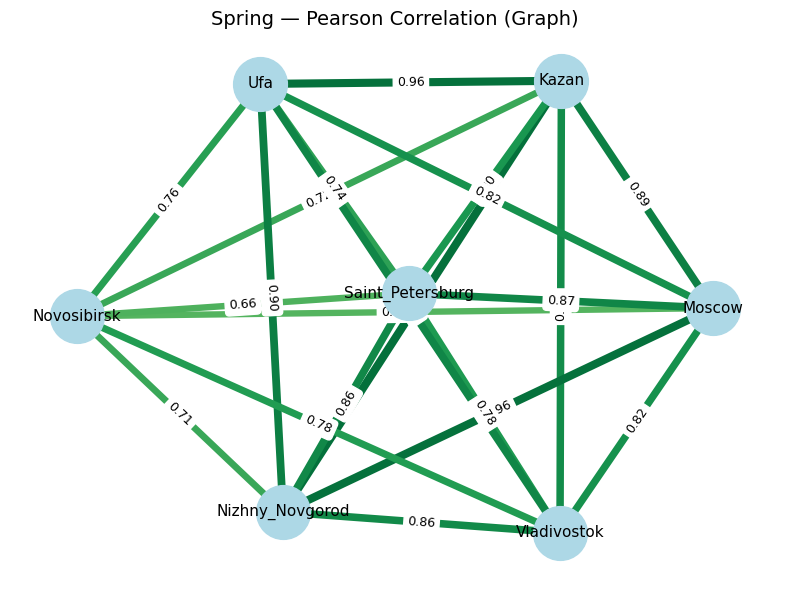

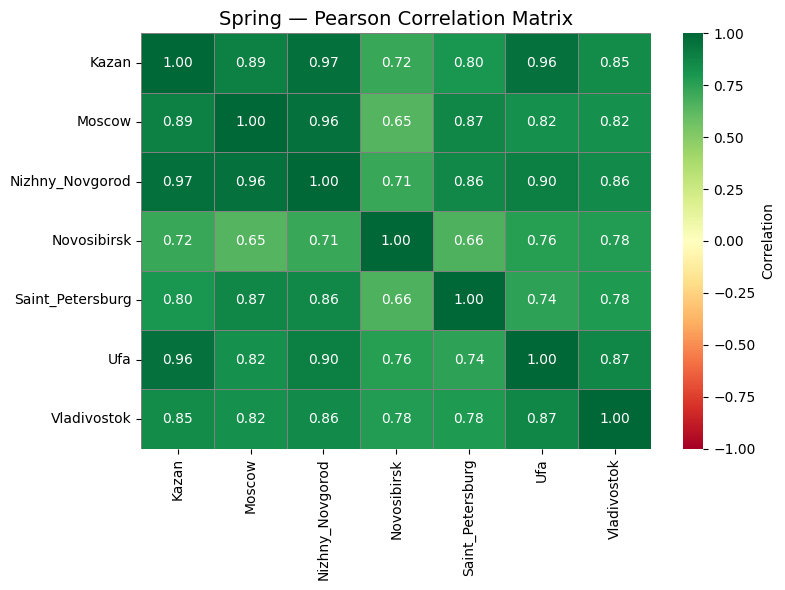

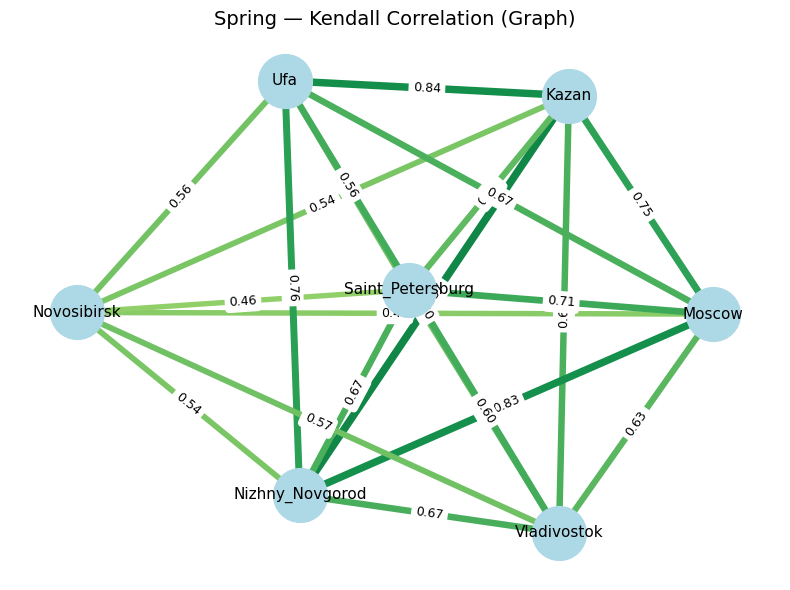

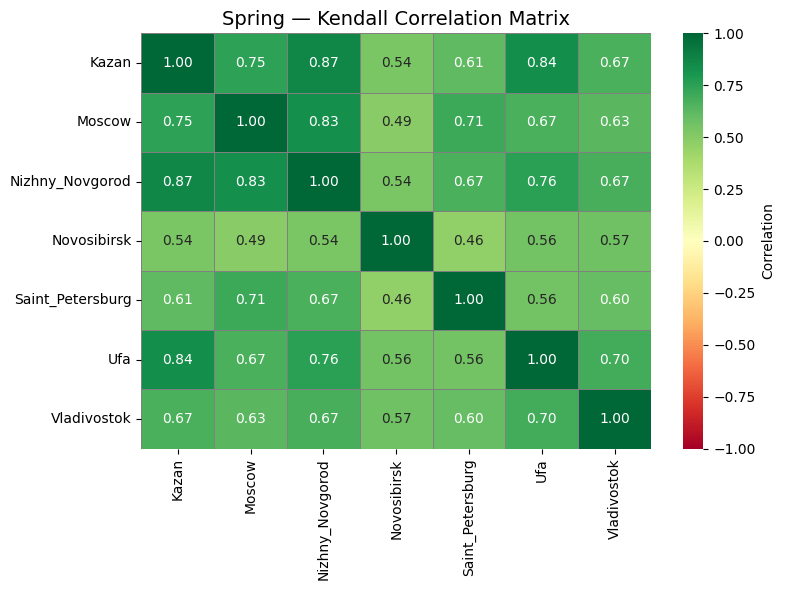

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

def draw_graph_for_season(graphs_dict, season='spring', method='pearson', threshold=None):
    G = graphs_dict.get((season, method))
    if not G or len(G.nodes) == 0:
        print(f"⚠️ Нет данных для {season.title()} ({method})")
        return

    pos = nx.spring_layout(G, seed=42)

    # Применим фильтр по порогу корреляции
    edges = [(u, v) for u, v, d in G.edges(data=True)
             if threshold is None or abs(d['weight']) >= threshold]
    if not edges:
        print(f"⚠️ Нет рёбер выше порога {threshold} для {season.title()}")
        return

    weights = [G[u][v]['weight'] for u, v in edges]
    abs_weights = [abs(w) for w in weights]

    # Цвета рёбер: от красного (-1) до зелёного (+1)
    edge_colors = [plt.cm.RdYlGn((w + 1) / 2) for w in weights]
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges}

    # Визуализация графа
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)
    nx.draw_networkx_labels(G, pos, font_size=11)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors,
                           width=[2 + 4 * w for w in abs_weights])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(f"{season.title()} — {method.title()} Correlation (Graph)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Построение корреляционной матрицы
    nodes = list(G.nodes)
    corr_matrix = pd.DataFrame(index=nodes, columns=nodes, dtype=float)

    for u in nodes:
        for v in nodes:
            if u == v:
                corr_matrix.loc[u, v] = 1.0
            elif G.has_edge(u, v):
                corr_matrix.loc[u, v] = G[u][v]['weight']
            elif G.has_edge(v, u):
                corr_matrix.loc[u, v] = G[v][u]['weight']
            else:
                corr_matrix.loc[u, v] = None

    # Визуализация тепловой карты
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='RdYlGn', vmin=-1, vmax=1,
                linewidths=0.5, linecolor='gray', cbar_kws={"label": "Correlation"})
    plt.title(f"{season.title()} — {method.title()} Correlation Matrix", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Пример: сравнение по сезонам для дневных наблюдений
draw_graph_for_season(daily_graphs, method='pearson')
draw_graph_for_season(daily_graphs, method='kendall')

# 3. Построение графов с порогом корреляции + клики и независимые множества

In [5]:
#функция отсечения графа 

from networkx.algorithms.clique import find_cliques
from networkx.algorithms.approximation import maximum_independent_set

def threshold_graph(G: nx.Graph, threshold: float) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G.nodes)
    for u, v, data in G.edges(data=True):
        if abs(data['weight']) >= threshold:
            H.add_edge(u, v, weight=data['weight'])
    return H

# функция которая находит клики + независимые множества
def analyze_graph(G: nx.Graph, threshold: float):
    G_thresh = threshold_graph(G, threshold)

    cliques = list(find_cliques(G_thresh))  # Все клики (не обязательно максимальные)
    max_clique_size = max(len(c) for c in cliques) if cliques else 0
    largest_cliques = [c for c in cliques if len(c) == max_clique_size]

    independent_set = maximum_independent_set(G_thresh)

    return {
        'thresholded_graph': G_thresh,
        'cliques': cliques,
        'largest_cliques': largest_cliques,
        'independent_set': independent_set
    }

In [6]:
# это пример использования функции выделения клик + независимых множеств

thresholds = [0.2, 0.4, 0.7]

for season in ['winter', 'spring', 'summer', 'autumn']:
    for method in ['pearson', 'kendall']:
        G = hourly_graphs.get((season, method))
        if G is None:
            continue
        print(f"\n--- {season.title()} | {method.title()} ---")
        for t in thresholds:
            result = analyze_graph(G, t)
            print(f"\nПорог: {t}")
            print(f"🔹 Кол-во вершин в кликах: {len(result['cliques'])}")
            print(f"🔹 Наибольшие клики: {result['largest_cliques']}")
            print(f"🔹 Независимое множество: {result['independent_set']}")


--- Winter | Pearson ---

Порог: 0.2
🔹 Кол-во вершин в кликах: 3
🔹 Наибольшие клики: [['Nizhny_Novgorod', 'Ufa', 'Kazan', 'Moscow', 'Saint_Petersburg']]
🔹 Независимое множество: {'Moscow', 'Novosibirsk'}

Порог: 0.4
🔹 Кол-во вершин в кликах: 4
🔹 Наибольшие клики: [['Kazan', 'Nizhny_Novgorod', 'Moscow', 'Ufa'], ['Kazan', 'Nizhny_Novgorod', 'Moscow', 'Saint_Petersburg']]
🔹 Независимое множество: {'Ufa', 'Saint_Petersburg'}

Порог: 0.7
🔹 Кол-во вершин в кликах: 5
🔹 Наибольшие клики: [['Nizhny_Novgorod', 'Kazan', 'Moscow'], ['Nizhny_Novgorod', 'Kazan', 'Ufa']]
🔹 Независимое множество: {'Vladivostok', 'Saint_Petersburg', 'Kazan', 'Novosibirsk'}

--- Winter | Kendall ---

Порог: 0.2
🔹 Кол-во вершин в кликах: 4
🔹 Наибольшие клики: [['Kazan', 'Nizhny_Novgorod', 'Moscow', 'Ufa'], ['Kazan', 'Nizhny_Novgorod', 'Moscow', 'Saint_Petersburg']]
🔹 Независимое множество: {'Ufa', 'Saint_Petersburg'}

Порог: 0.4
🔹 Кол-во вершин в кликах: 5
🔹 Наибольшие клики: [['Nizhny_Novgorod', 'Kazan', 'Moscow'], ['N

In [7]:
#функция визуализации отсеченного графа
def draw_thresholded_graph(G: nx.Graph, threshold=0.7, title=''):
    G_thresh = threshold_graph(G, threshold)
    
    if G_thresh.number_of_edges() == 0:
        print(f"⚠️ Нет рёбер выше порога {threshold}")
        return

    pos = nx.spring_layout(G_thresh, seed=42)

    edges = list(G_thresh.edges(data=True))
    weights = [d['weight'] for _, _, d in edges]
    abs_weights = [abs(w) for w in weights]
    edge_colors = [plt.cm.RdYlGn((w + 1) / 2) for w in weights]
    edge_labels = {(u, v): f"{w:.2f}" for u, v, d in edges if (w := d['weight'])}

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G_thresh, pos, node_color='lightblue', node_size=1500)
    nx.draw_networkx_labels(G_thresh, pos, font_size=11)
    nx.draw_networkx_edges(G_thresh, pos, edgelist=[(u, v) for u, v, _ in edges],
                           edge_color=edge_colors,
                           width=[2 + 4 * w for w in abs_weights])
    nx.draw_networkx_edge_labels(G_thresh, pos, edge_labels=edge_labels, font_size=9)
    
    plt.title(title or f"Thresholded Graph (≥ {threshold})", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

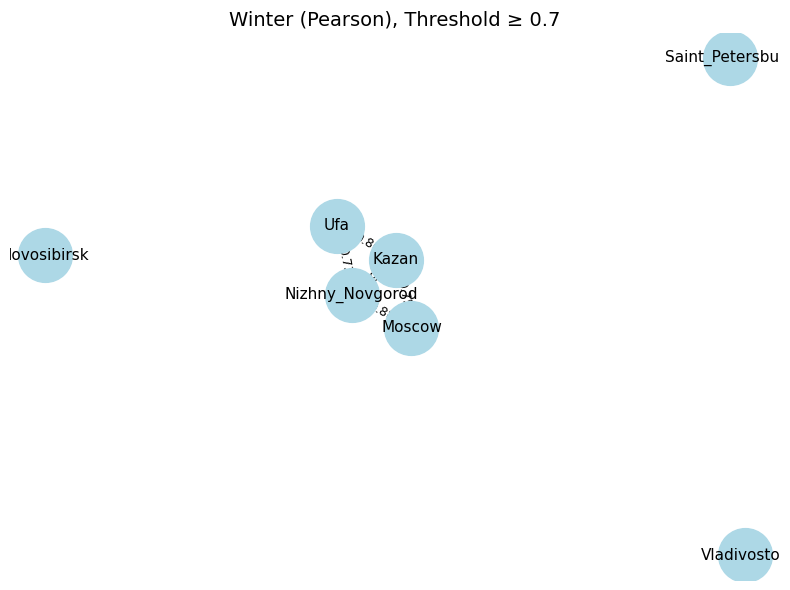

In [8]:
#визуализация зимнего графа пирсона из почасовых данных при пороге 0.7:
G = hourly_graphs[('winter', 'pearson')]
draw_thresholded_graph(G, threshold=0.7, title='Winter (Pearson), Threshold ≥ 0.7')

# 4. Анализ гипотезы

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, kendalltau, ttest_ind

def compare_graphs_extended(graph_sets, methods=['pearson', 'kendall'], verbose=True):
    results = []

    seasons = ['winter', 'spring', 'summer', 'autumn']
    freqs = ['hourly', 'daily', 'monthly']
    freq_labels = {
        'hourly': 'Почасовые',
        'daily': 'Дневные',
        'monthly': 'Месячные'
    }

    hypothesis_rejected = False  # Флаг для отслеживания отклонения гипотезы

    for freq1 in freqs:
        for freq2 in freqs:
            for season1 in seasons:
                for season2 in seasons:
                    for method1 in methods:
                        for method2 in methods:
                            G1 = graph_sets[freq1].get((season1, method1))
                            G2 = graph_sets[freq2].get((season2, method2))

                            if not G1 or not G2:
                                continue

                            nodes = sorted(set(G1.nodes) & set(G2.nodes))
                            if len(nodes) < 2:
                                continue

                            def get_matrix(G, nodes):
                                mat = np.zeros((len(nodes), len(nodes)))
                                for i, u in enumerate(nodes):
                                    for j, v in enumerate(nodes):
                                        if i == j:
                                            mat[i, j] = 1.0
                                        elif G.has_edge(u, v):
                                            mat[i, j] = G[u][v]['weight']
                                        elif G.has_edge(v, u):
                                            mat[i, j] = G[v][u]['weight']
                                return mat

                            mat1 = get_matrix(G1, nodes).flatten()
                            mat2 = get_matrix(G2, nodes).flatten()

                            mse = mean_squared_error(mat1, mat2)
                            if method1 == 'pearson':
                                corr, _ = pearsonr(mat1, mat2)
                            else:  # Кендалл
                                corr, _ = kendalltau(mat1, mat2)

                            # Тест гипотезы (t-тест для независимых выборок)
                            t_stat, p_value = ttest_ind(mat1, mat2, equal_var=False)

                            results.append({
                                'freq1': freq_labels[freq1],
                                'season1': season1,
                                'method1': method1,
                                'freq2': freq_labels[freq2],
                                'season2': season2,
                                'method2': method2,
                                'mse': round(mse, 5),
                                'corr': round(corr, 5),
                                't_statistic': round(t_stat, 5),
                                'p_value': round(p_value, 5)
                            })

                            # Проверка гипотезы для текущего сравнения
                            if p_value < 0.05:
                                hypothesis_rejected = True

    df = pd.DataFrame(results)

    if verbose:
        print(df.head(10))  # Пример вывода
        print(f"\nВсего сравнений: {len(df)}")

    # Визуализация
    plot_correlation_heatmap(df)
    plot_mse_heatmap(df)
    plot_method_comparison(df)

    # Вывод результата гипотезы
    if hypothesis_rejected:
        print("\nГипотеза отклоняется: существуют статистически значимые различия между графами.")
    else:
        print("\nГипотеза принимается: нет статистически значимых различий между графами.")

    return df


def plot_correlation_heatmap(df):
    pivot_corr = df.pivot_table(index=['season1', 'season2'], columns=['freq1', 'freq2'], values='corr')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Корреляции между графами по сезонам и частотам", fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_mse_heatmap(df):
    pivot_mse = df.pivot_table(index=['season1', 'season2'], columns=['freq1', 'freq2'], values='mse')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_mse, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=0.5)
    plt.title("MSE (среднеквадратичные ошибки) между графами по сезонам и частотам", fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_method_comparison(df):
    # Сравнение корреляций Пирсона и Кендалла для одинаковых сезонов и частот
    comparison_df = df[df['method1'] == df['method2']]
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='season1', y='corr', hue='method1', data=comparison_df)
    plt.title("Сравнение корреляций Пирсона и Кендалла по сезонам", fontsize=16)
    plt.tight_layout()
    plt.show()

       freq1 season1  method1      freq2 season2  method2      mse     corr
0  Почасовые  winter  pearson  Почасовые  winter  pearson  0.00000  1.00000
1  Почасовые  winter  pearson  Почасовые  winter  kendall  0.03034  0.95474
2  Почасовые  winter  kendall  Почасовые  winter  pearson  0.03034  0.97884
3  Почасовые  winter  kendall  Почасовые  winter  kendall  0.00000  1.00000
4  Почасовые  winter  pearson  Почасовые  spring  pearson  0.28386  0.70279
5  Почасовые  winter  pearson  Почасовые  spring  kendall  0.16858  0.71092
6  Почасовые  winter  kendall  Почасовые  spring  pearson  0.33727  0.63316
7  Почасовые  winter  kendall  Почасовые  spring  kendall  0.18350  0.62610
8  Почасовые  winter  pearson  Почасовые  summer  pearson  0.09602  0.81885
9  Почасовые  winter  pearson  Почасовые  summer  kendall  0.07023  0.81665

Всего сравнений: 576

Тест гипотезы для зимы и лета: t-статистика = -2.839, p-значение = 0.005
Гипотеза отвергается: Есть статистически значимые различия между зим

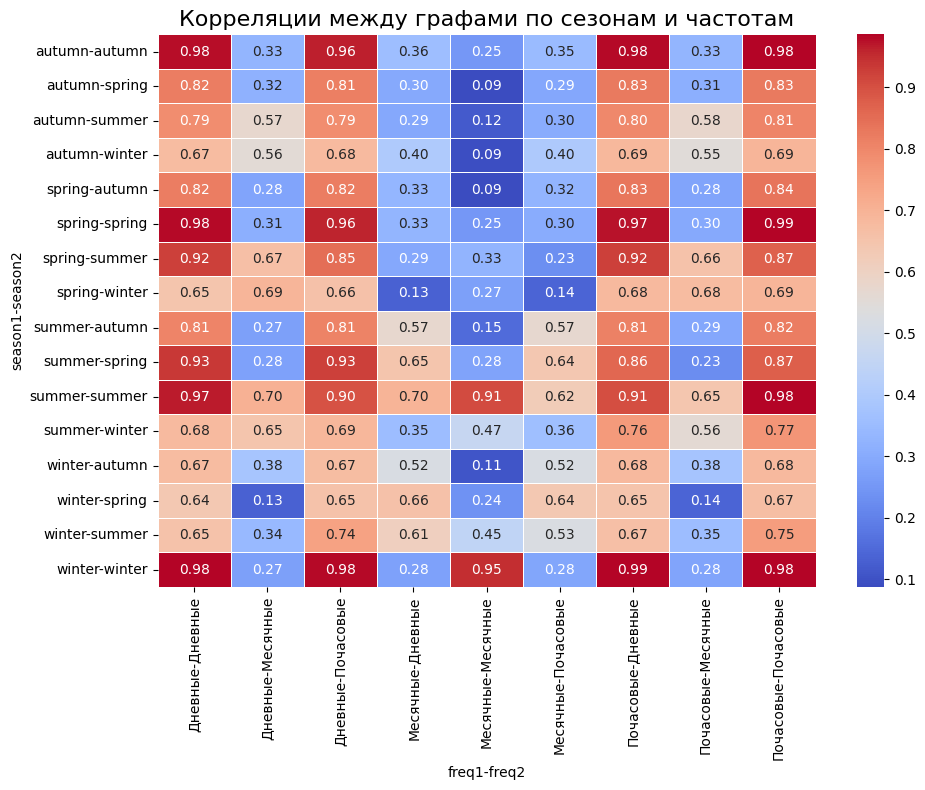

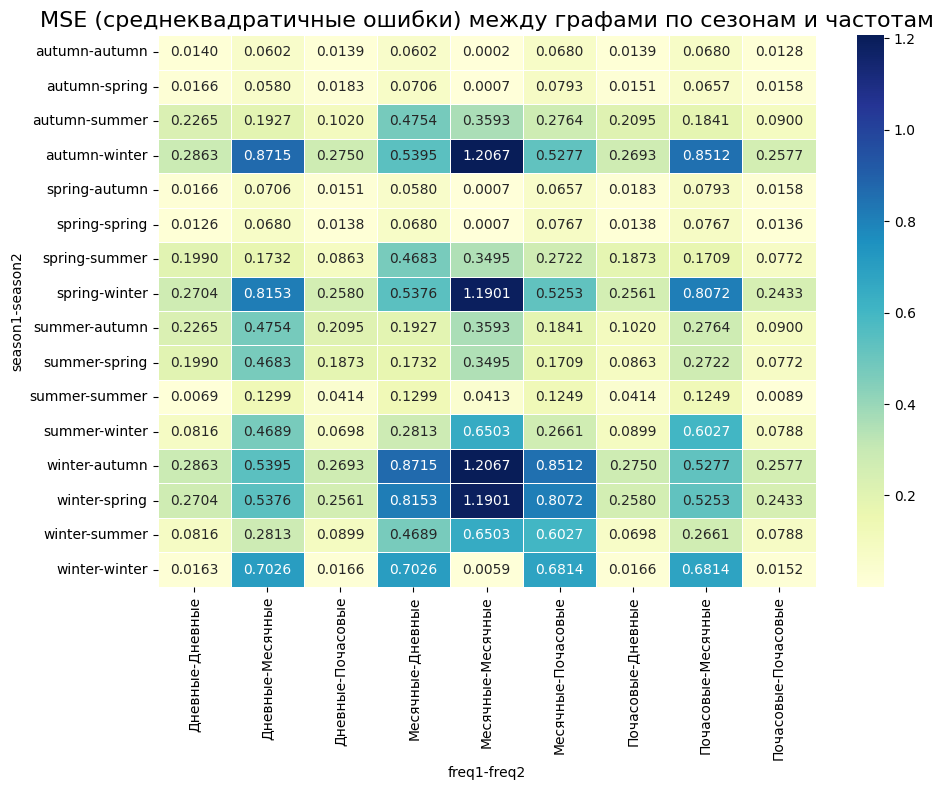

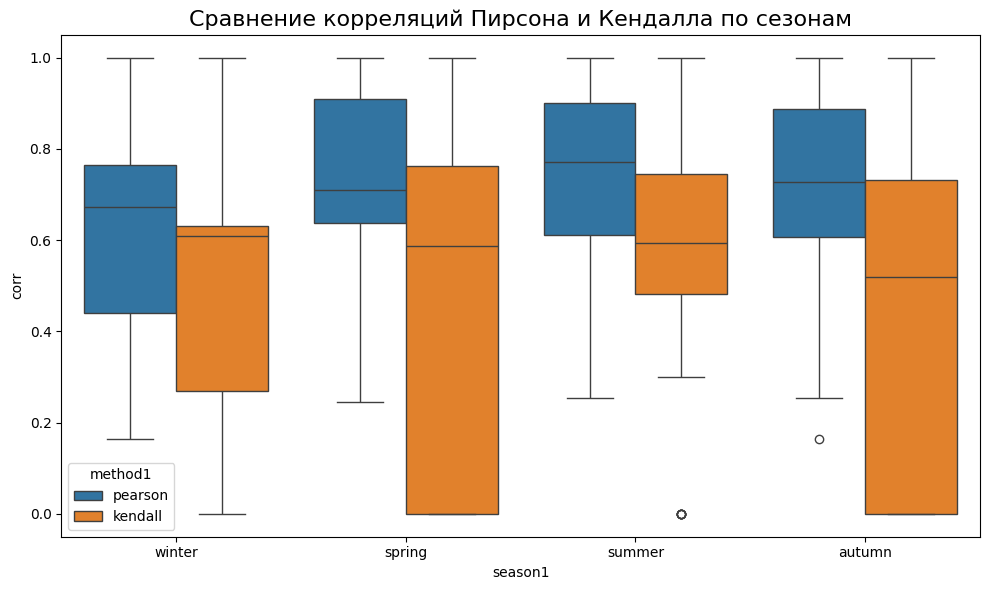

In [14]:
graph_sets = {
    'hourly': hourly_graphs,
    'daily': daily_graphs,
    'monthly': monthly_graphs
}

df_comparison_all = compare_graphs_extended(graph_sets)

In [18]:
import pandas as pd
import scipy.stats as stats

def season_and_frequency_comparison_test(graph_sets, methods=['pearson', 'kendall']):
    seasons = ['winter', 'spring', 'summer', 'autumn']
    freqs = ['hourly', 'daily', 'monthly']
    results = []

    # Пробегаем все комбинации частот и сезонов
    for freq1 in freqs:
        for freq2 in freqs:
            for season1 in seasons:
                for season2 in seasons:
                    if season1 == season2:
                        continue  # Пропускаем сравнение одинаковых сезонов

                    for method1 in methods:
                        for method2 in methods:
                            # Получаем графы для разных сезонов, методов и частот
                            G1 = graph_sets[freq1].get((season1, method1))
                            G2 = graph_sets[freq2].get((season2, method2))

                            if not G1 or not G2:
                                continue

                            # Получаем узлы, которые есть в обоих графах
                            nodes = sorted(set(G1.nodes) & set(G2.nodes))
                            if len(nodes) < 2:
                                continue

                            def get_matrix(G, nodes):
                                mat = np.zeros((len(nodes), len(nodes)))
                                for i, u in enumerate(nodes):
                                    for j, v in enumerate(nodes):
                                        if i == j:
                                            mat[i, j] = 1.0
                                        elif G.has_edge(u, v):
                                            mat[i, j] = G[u][v]['weight']
                                        elif G.has_edge(v, u):
                                            mat[i, j] = G[v][u]['weight']
                                return mat

                            mat1 = get_matrix(G1, nodes).flatten()
                            mat2 = get_matrix(G2, nodes).flatten()

                            # Выполняем t-тест для парных выборок (H0: нет различий)
                            t_stat, p_value = stats.ttest_ind(mat1, mat2)

                            # Сохраняем результаты в список
                            results.append({
                                'season1': season1,
                                'season2': season2,
                                'freq1': freq1,
                                'freq2': freq2,
                                'method1': method1,
                                'method2': method2,
                                't_statistic': round(t_stat, 3),
                                'p_value': round(p_value, 3)
                            })

    # Преобразуем список в DataFrame для удобства
    df = pd.DataFrame(results)

    # Печатаем таблицу с чёткими разделителями
    print(df.to_string(index=False))  # Печатает таблицу с чёткими границами

    return df

# Пример использования
df_results = season_and_frequency_comparison_test(graph_sets=graph_sets)

# Отобразим таблицу с результатами
df_results_pivoted = df_results.pivot_table(
    index=['season1', 'season2'],
    columns=['freq1', 'freq2'],
    values=['t_statistic', 'p_value'],
    aggfunc='first'
)

# Печатаем таблицу с результатами
print("\nРезультаты t-тестов для разных сезонов и частот:")
print(df_results_pivoted.to_string())  # Печатает таблицу с чёткими границами

season1 season2   freq1   freq2 method1 method2  t_statistic  p_value
 winter  spring  hourly  hourly pearson pearson       -6.127    0.000
 winter  spring  hourly  hourly pearson kendall       -3.604    0.000
 winter  spring  hourly  hourly kendall pearson       -9.066    0.000
 winter  spring  hourly  hourly kendall kendall       -6.030    0.000
 winter  summer  hourly  hourly pearson pearson       -2.118    0.037
 winter  summer  hourly  hourly pearson kendall       -0.406    0.686
 winter  summer  hourly  hourly kendall pearson       -4.137    0.000
 winter  summer  hourly  hourly kendall kendall       -2.174    0.032
 winter  autumn  hourly  hourly pearson pearson       -6.453    0.000
 winter  autumn  hourly  hourly pearson kendall       -3.996    0.000
 winter  autumn  hourly  hourly kendall pearson       -9.438    0.000
 winter  autumn  hourly  hourly kendall kendall       -6.480    0.000
 spring  winter  hourly  hourly pearson pearson        6.127    0.000
 spring  winter  hou

/Users/d3zzle/HSE_proj/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


# 5. Выводы